In [23]:
its_jupyter_notebook = True

In [24]:
import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from pathlib import Path
import argparse
import math
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc

sys.path.insert(0, '..')

from util.xai import gradcam, interpolate_expl_matrix, plot_matrix
from config import *
from models.nt_classifier import build as build_model 
from util.plot_utils import balance_df, obtain_plot, plot_logs, plot_roc_curves, collect_results_based_on_confidence_level
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!

In [25]:
how = 'ricseq'

In [26]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', 'modelarch1_easypretrain7_paristrain22') 
#2_pretrained3epoch_27_splashFT, model1_1_epoch14

In [27]:
test500 = pd.read_csv(os.path.join(metadata_dir, f'{how}500.csv'))
# test500['seed_w'] = test500['seed_x2'] - test500['seed_x1']
# test500['seed_h'] = test500['seed_y2'] - test500['seed_y1']

In [28]:
MIN_N_READS = 3

if how == 'ricseq':
    
#     import dataset.preprocessing as utils
#     info = utils.read_dataframe(os.path.join(original_files_dir, 'index_bio_regions.Tx.RI_ALL.txt'), columns_to_drop = ['Unnamed: 0'])
#     df = pd.read_csv(os.path.join(processed_files_dir, f'final_{how}_RANDOM_FULL.csv'))

    
#     filename = os.path.join(original_files_dir, 'Tx.RI_ALL.specie.no_abundant.filter_rep.no_mirna.no_mito.no_cds_cds.bedpe')

#     rows = []
#     with open(filename)as f:
#         for line in f:
#             L = line.strip().split()
#             rows.append(L)

#     all_interactions = pd.DataFrame(rows, columns = ['tr1', 'x1', 'x2', 'tr2', 'y1', 'y2', 'name', 'n_reads', 'strand1', 'strand2', 'other_id', 'experiment'] )
#     all_interactions['n_reads'] = all_interactions['n_reads'].apply(pd.to_numeric)
#     all_interactions = all_interactions[all_interactions['experiment'] == 'hs_RIC-seq__HeLa_merge.InterGene.arms']
#     all_interactions = all_interactions[all_interactions.n_reads>=MIN_N_READS]

#     merged = all_interactions.merge(info, on = 'name')
#     merged = merged[['ensembl_gene_id_1', 'ensembl_gene_id_2', 'x1', 'x2', 'y1', 'y2']].rename({'ensembl_gene_id_1':'gene_id1', 'ensembl_gene_id_2':'gene_id2'}, axis = 1)
#     merged[['couples', 'need_to_swap']] = merged[['gene_id1', 'gene_id2']].apply(utils.create_pairs, axis = 1)

#     def swap_genes_if_needed(df):
#         original_dim = df.shape[0]
#         where = df.need_to_swap
#         df.loc[where, ['gene_id1', 'gene_id2']] = (df.loc[where, ['gene_id2', 'gene_id1']].values)
#         df.loc[where, ['x1', 'y1']] = (df.loc[where, ['y1', 'x1']].values)
#         df.loc[where, ['x2', 'y2']] = (df.loc[where, ['y2', 'x2']].values)
#         df = df.drop('need_to_swap', axis = 1)
#         df = df.drop_duplicates().reset_index(drop = True)
#         n_duplicates = original_dim - df.shape[0] 
#         return df

#     merged = swap_genes_if_needed(merged)
#     merged[['x1', 'x2', 'y1', 'y2']] = merged[['x1', 'x2', 'y1', 'y2']].apply(pd.to_numeric)
#     hq_test = test500.copy()

#     regex1 = hq_test.gene1.str.extractall('(.*)_(.*)_(.*)').reset_index()
#     regex2 = hq_test.gene2.str.extractall('(.*)_(.*)_(.*)').reset_index()
#     hq_test['g1g2_id'] = regex1[0] + '_' + regex2[0]
#     hq_test['x1_window'] = regex1[1]
#     hq_test['y1_window'] = regex2[1]
#     hq_test[['x1_window', 'y1_window']] = hq_test[['x1_window', 'y1_window']].apply(pd.to_numeric)
    
#     hq_test['real_seed_x1'] = hq_test['x1_window'] + hq_test['seed_x1']
#     hq_test['real_seed_x2'] = hq_test['x1_window'] + hq_test['seed_x2']
#     hq_test['real_seed_y1'] = hq_test['y1_window'] + hq_test['seed_y1']
#     hq_test['real_seed_y2'] = hq_test['y1_window'] + hq_test['seed_y2']

#     hq_test = hq_test[['couples', 'g1g2_id', 'real_seed_x1', 'real_seed_x2', 'real_seed_y1', 'real_seed_y2']].rename(
#         {'couples':'real_id_couple', 'g1g2_id': 'couples', 'real_seed_x1':'x1', 'real_seed_x2':'x2', 
#          'real_seed_y1':'y1', 'real_seed_y2':'y2'}, axis = 1)
#     final_merge = hq_test.merge(merged, on = ['couples', 'x1', 'x2', 'y1', 'y2'])
#     real_hq = set(final_merge.real_id_couple)
#     real_hq_couples = set(final_merge.couples)
    
#     res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))
#     res_pos, res_neg = res[res.ground_truth == 1], res[res.ground_truth == 0] 


#     df_pairs_full = pd.read_csv(os.path.join(processed_files_dir, 'df_pairs_full_RANDOM_RICSEQ.csv'))
#     sampled_negatives = set(df_pairs_full[df_pairs_full.positive.isin(real_hq_couples)].negative)
#     res_neg = res_neg[res_neg.couples.isin(sampled_negatives)|res_neg.couples.isin(real_hq_couples)]

#     res = pd.concat([res_pos[res_pos.id_sample.isin(real_hq)], res_neg], axis = 0)

#     print(f'{res_pos.shape[0] - res_pos[res_pos.id_sample.isin(real_hq)].shape[0]} couples are excluded because they are not supported by enough reads')
#     print(f'The actual # of positives is {res_pos[res_pos.id_sample.isin(real_hq)].shape[0]}')
#     print(f'The actual # of unique pairs is {len(res_pos[res_pos.id_sample.isin(real_hq)].couples.unique())}')
#     print('\n\n METRICS:')
#     print(classification_report(res.ground_truth, res.prediction))
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))
elif how in ['mario', 'splash']:
    res = pd.read_csv(os.path.join(checkpoint_dir, f'{how}_results500.csv'))
    print('METRICS:')
    print(classification_report(res.ground_truth, res.prediction))

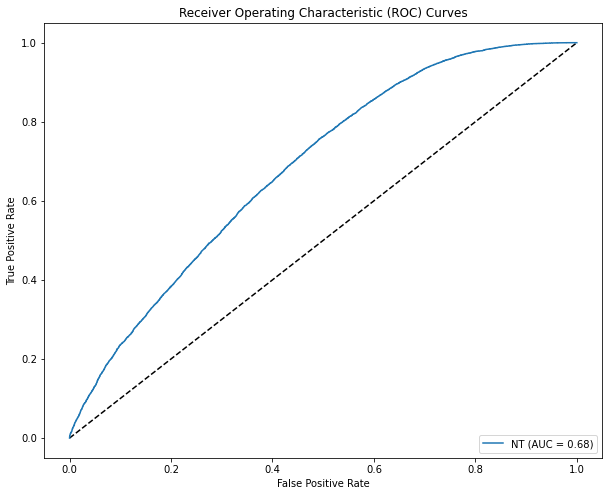

In [29]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                ], res.ground_truth)

In [30]:
intarna = pd.read_csv(os.path.join(intarna_dir, f'{how}500_RANDOM', f'{how}.csv'), sep = ';')
intarna['key'] = intarna.id1 + '_' + intarna.id2

# keep only the lower E_norm for each group
intarna.sort_values('E_norm', ascending = False, inplace=True)
intarna.drop_duplicates(subset='key', keep='first', inplace=True)
intarna = intarna.reset_index(drop = True)
intarna['couples'] = intarna.id1.str.extractall('(.*)_(.*)').reset_index(drop = True)[0]
intarna['couples'] = intarna['couples'].astype(int)

intarna = intarna.dropna()

# #merge with id of df_nt
# df_nt = pd.read_csv(os.path.join(metadata_dir, f'df_nt.csv'))
# df_nt = df_nt[['couples', 'interacting']]
# df_nt['interacting'] = df_nt['interacting'].astype(int)

res = res.merge(intarna[['E','E_norm', 'couples']].rename({'couples':'id_sample'}, axis =1), on = 'id_sample')

In [31]:
# exclude the common genes
# gene_count = pd.concat([res.gene1_original, res.gene2_original]).value_counts()
# rare_genes = list(gene_count[gene_count<20].index)
# res = res[res.gene1_original.isin(rare_genes) & res.gene2_original.isin(rare_genes)]

# PLOTS

## Metrics

In [32]:
print(res.prediction.value_counts())
print('\n')
print(res.ground_truth.value_counts())

0    17907
1    12532
Name: prediction, dtype: int64


0    17124
1    13315
Name: ground_truth, dtype: int64


In [33]:
n_conf = 10

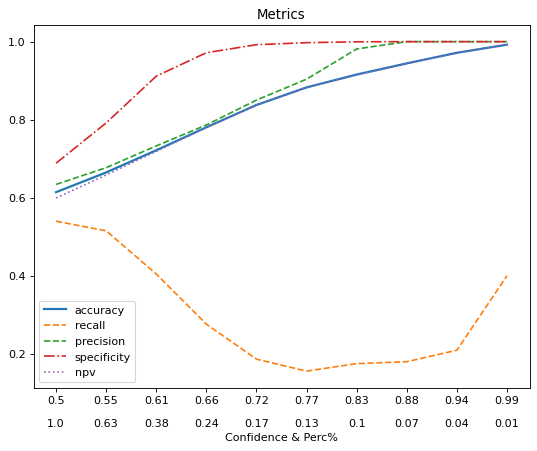

In [34]:
obtain_plot(balance_df(res), n_original_df = res.shape[0], title = 'Metrics', n_conf = n_conf)

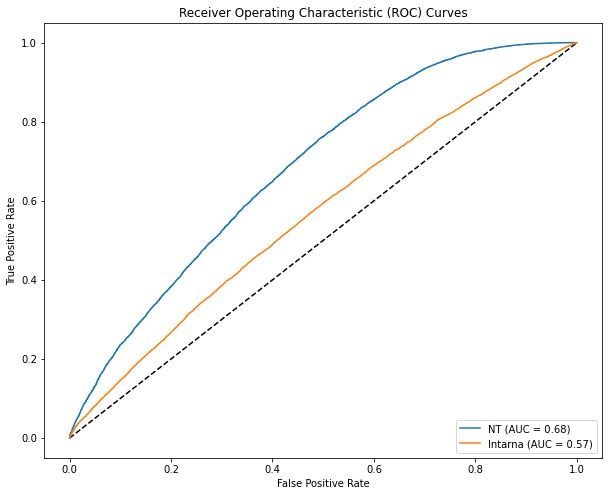

In [35]:
plot_roc_curves([{'prob': res.probability, 'model_name': 'NT'},
                 {'prob': abs(res.E_norm), 'model_name': 'Intarna'}
                ], res.ground_truth)

In [36]:
# no_pc = res[(res['gene1_pc'] == False)|(res['gene2_pc'] == False)]

# obtain_plot(balance_df(no_pc), n_original_df = res.shape[0], title = f'Metrics: At least one is no protein coding', n_conf = n_conf)

0.5384950237187238


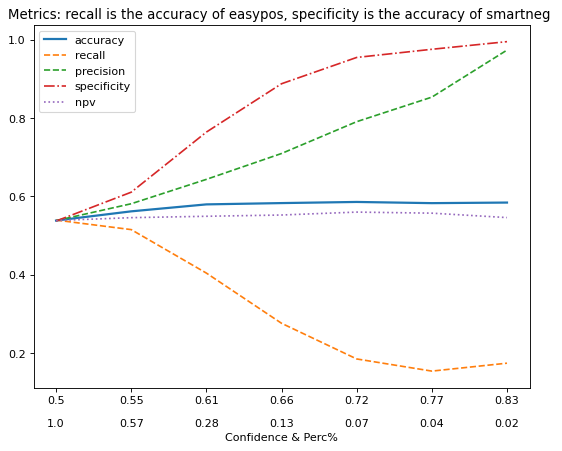

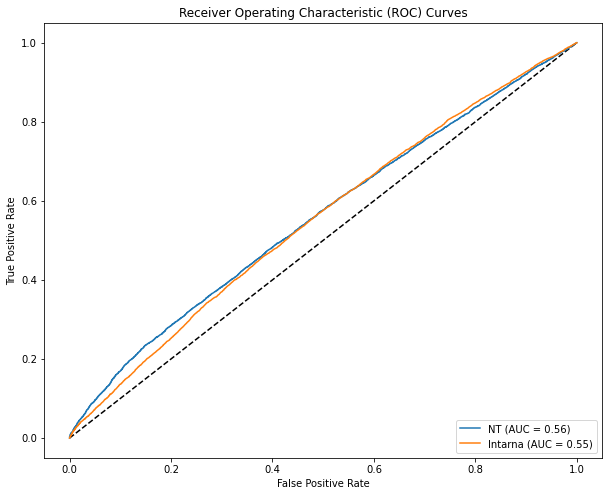

In [37]:
easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])]
balanced_epsn = balance_df(easypos_smartneg)

print(balanced_epsn[balanced_epsn.ground_truth == balanced_epsn.prediction].shape[0]/balanced_epsn.shape[0])

obtain_plot(balanced_epsn, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg ', n_conf = n_conf)
plot_roc_curves([{'prob': balanced_epsn.probability, 'model_name': 'NT'},
                 {'prob': abs(balanced_epsn.E_norm), 'model_name': 'Intarna'}
                ], balanced_epsn.ground_truth)

0.5515444617784712


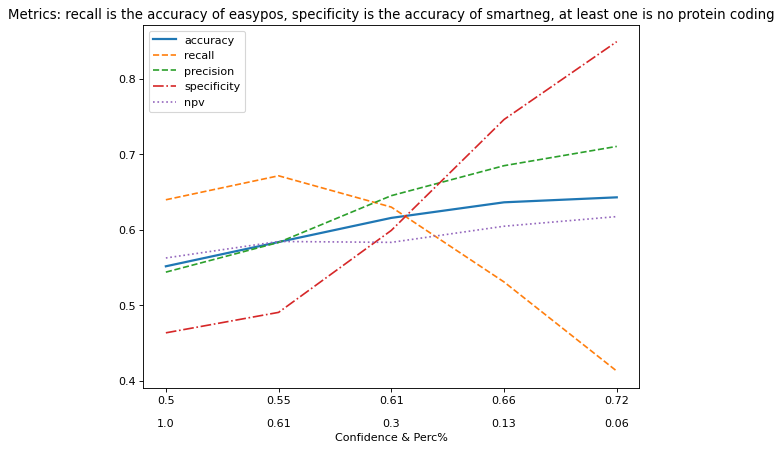

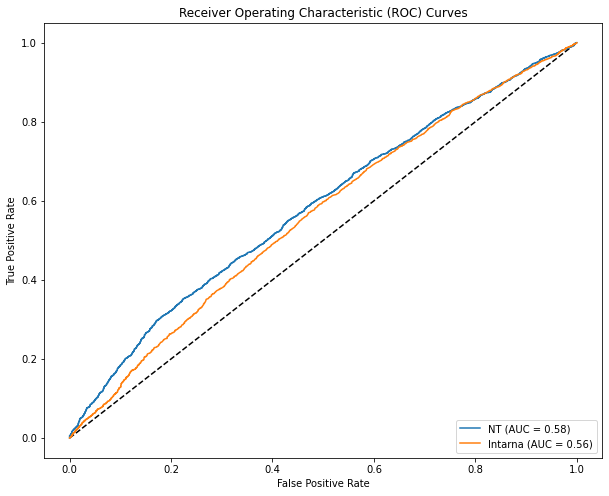

In [41]:
nopc = easypos_smartneg[(easypos_smartneg.gene1_pc == False)|(easypos_smartneg.gene2_pc == False)]
if how =='splash':
    print(nopc.shape[0])
    print(nopc[nopc.ground_truth == nopc.prediction].shape[0]/nopc.shape[0])

else:
    balanced_epsn_nopc = balance_df(nopc)
    print(balanced_epsn_nopc[balanced_epsn_nopc.ground_truth == balanced_epsn_nopc.prediction].shape[0]/balanced_epsn_nopc.shape[0])


    obtain_plot(balanced_epsn_nopc, n_original_df = res.shape[0], title = f'Metrics: recall is the accuracy of easypos, specificity is the accuracy of smartneg, at least one is no protein coding', 
                n_conf = n_conf, excluding_treshold = 0.05)

    plot_roc_curves([{'prob': nopc.probability, 'model_name': 'NT'},
                     {'prob': abs(nopc.E_norm), 'model_name': 'Intarna'}
                    ], nopc.ground_truth)

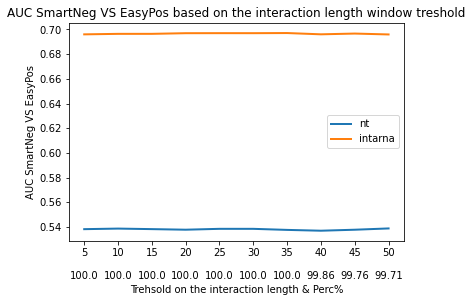

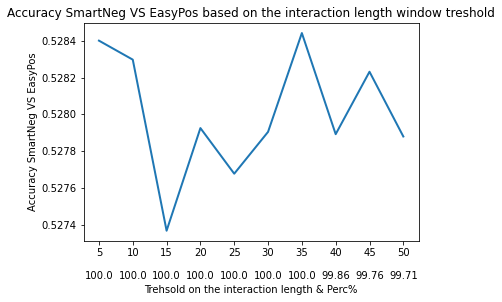

In [106]:
MIN_PERC = 1

def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

def obtain_acc_and_perc(treshold, res, test500, balance = True):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)

    acc = (res.prediction == res.ground_truth).sum()/res.shape[0]
    return acc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
accuracies = []
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    acc, perc = obtain_acc_and_perc(treshold, easypos_smartneg, test500)
    if perc > MIN_PERC:
        accuracies.append(acc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = False)
        aucs_nt.append(roc_auc)
        roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = True, intarna = True)
        aucs_intarna.append(roc_auc)
        percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

plt.show()


merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('Accuracy SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, accuracies, label = 'accuracy', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"Accuracy SmartNeg VS EasyPos")

plt.show()

1.0


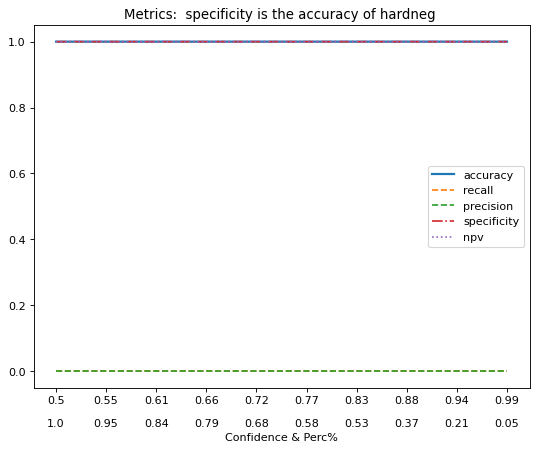

In [107]:
hn = res[(res.policy == 'hardneg')]
print(hn[hn.ground_truth == hn.prediction].shape[0]/hn.shape[0])

obtain_plot(hn, n_original_df = res.shape[0], title = f'Metrics:  specificity is the accuracy of hardneg ', n_conf = n_conf)

0.9444444444444444


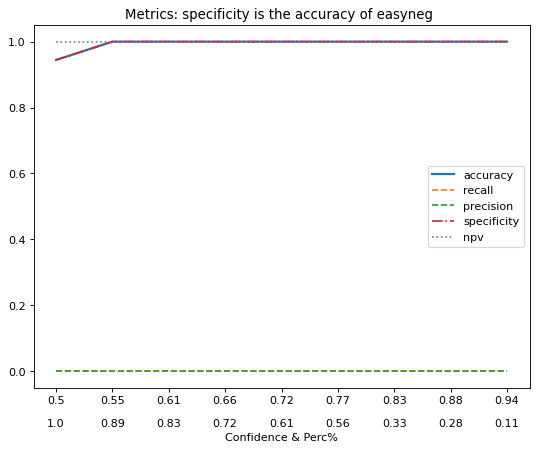

In [108]:
easy = res[(res.policy == 'easyneg')]
print(easy[easy.ground_truth == easy.prediction].shape[0]/easy.shape[0])

obtain_plot(easy, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg ', n_conf = n_conf)

0.7323688969258589


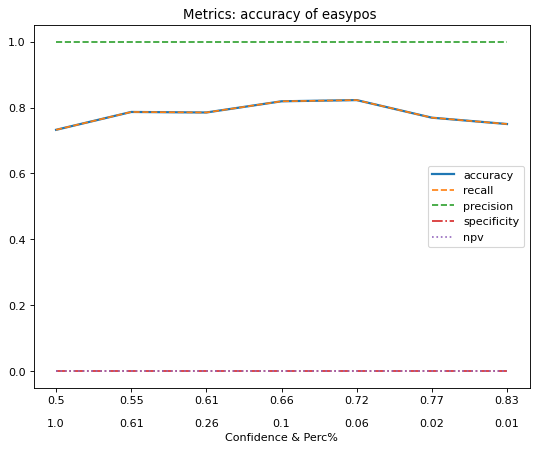

In [109]:
ep = res[(res.policy == 'easypos')]
print(ep[ep.ground_truth == ep.prediction].shape[0]/ep.shape[0])

obtain_plot(ep, n_original_df = res.shape[0], title = f'Metrics: accuracy of easypos ', n_conf = n_conf)

0.3240454076367389


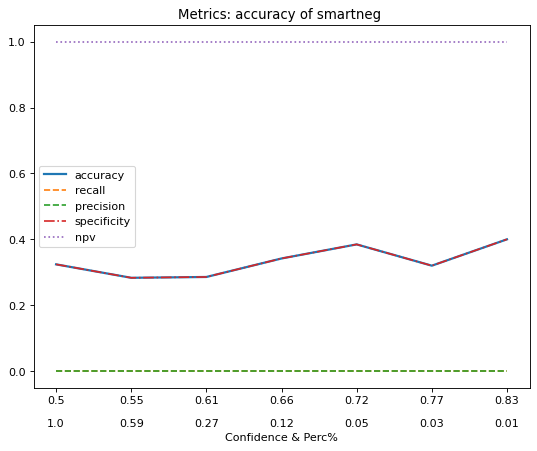

In [110]:
sn = res[(res.policy == 'smartneg')]
print(sn[sn.ground_truth == sn.prediction].shape[0]/sn.shape[0])

obtain_plot(sn, n_original_df = res.shape[0], title = f'Metrics: accuracy of smartneg ', n_conf = n_conf)

0.8572972972972973


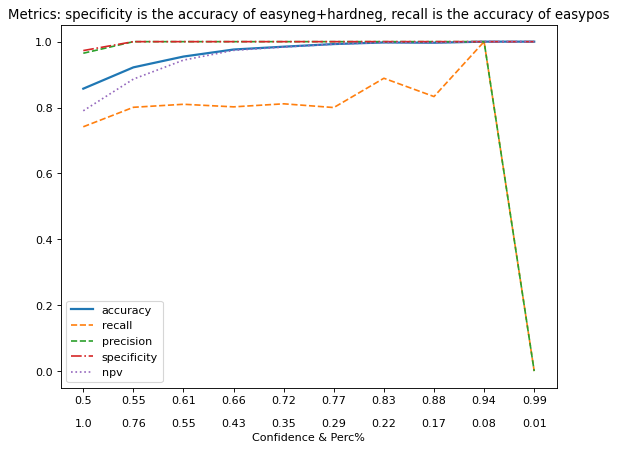

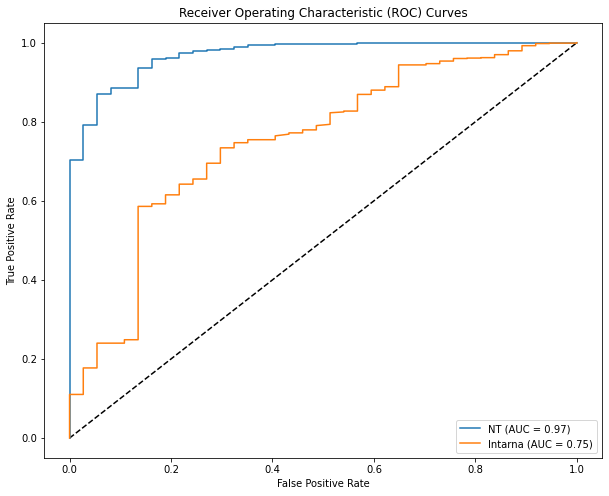

In [111]:
ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')]

ephnen_sampled = balance_df(ephnen)

print(ephnen_sampled[ephnen_sampled.ground_truth == ephnen_sampled.prediction].shape[0]/ephnen_sampled.shape[0])
obtain_plot(ephnen_sampled, n_original_df = res.shape[0], title = f'Metrics: specificity is the accuracy of easyneg+hardneg, recall is the accuracy of easypos', n_conf = n_conf)
plot_roc_curves([{'prob': ephnen_sampled.probability, 'model_name': 'NT'},
                 {'prob': abs(ephnen_sampled.E_norm), 'model_name': 'Intarna'}
                ], ephnen_sampled.ground_truth)

In [112]:
# confidence_level = 0.7
# high_prob_pairs = easypos_smartneg[(easypos_smartneg.probability>confidence_level)|(easypos_smartneg.probability<(1-confidence_level))]

# obtain_plot(balance_df(high_prob_pairs), n_original_df = easypos_smartneg.shape[0], title = f'Metrics: The model is very confident (easypos VS smartneg) ', n_conf = n_conf)
# plot_roc_curves([{'prob': high_prob_pairs.probability, 'model_name': 'NT-predictor'}], high_prob_pairs.ground_truth)

In [92]:
# import dataset.preprocessing as utils
# def order_genes(x):
#     x1, x2 = x.split('_')
#     return utils.get_couple_id(x1, x2)

# prohibited_couples = pd.read_csv(os.path.join(original_files_dir, 'prohibited_couples.txt'), sep = '\t')
# prohibited_couples['messy_id'] = prohibited_couples['gene_id1'] + '_' + prohibited_couples['gene_id2']
# prohibited_couples['id'] = prohibited_couples['messy_id'].apply(order_genes)

# Compare with INTARNA

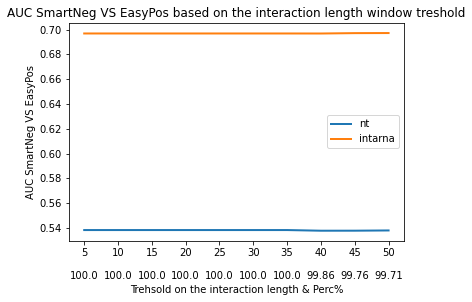

In [113]:
def obtain_auc_and_perc(treshold, res, test500, balance = True, intarna = False):
    original_res_shape = res.shape[0]
    #take only big windows
    subset = test500[ (abs(test500.seed_x1 - test500.seed_x2) >treshold) & (abs(test500.seed_y1 - test500.seed_y2) > treshold) ]
    res = res[res.id_sample.isin(subset.couples)]
    
    perc = np.round((res.shape[0] / original_res_shape)*100, 2)
    
    if balance:
        res = balance_df(res)
    
    if intarna:
        fpr, tpr, _ = roc_curve(abs(1 - res.ground_truth), res.E_norm)
        roc_auc = auc(fpr, tpr)
    else:
        fpr, tpr, _ = roc_curve(res.ground_truth, res.probability)
        roc_auc = auc(fpr, tpr)
    
    return roc_auc, perc

tresholds = np.linspace(5, 50, 10).astype(int)
aucs_nt = []
aucs_intarna = []
percs = []
for treshold in tresholds:
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = False)
    aucs_nt.append(roc_auc)
    roc_auc, perc = obtain_auc_and_perc(treshold, easypos_smartneg, test500, balance = False, intarna = True)
    aucs_intarna.append(roc_auc)
    percs.append(perc)

merged_x_axis = []
for i in range(0, len(percs)):
    tuple_to_print = (np.round(tresholds[i],2), np.round(percs[i], 2))
    merged_x_axis.append('\n\n'.join(str(x) for x in tuple_to_print))

plt.title('AUC SmartNeg VS EasyPos based on the interaction length window treshold')

plt.plot(merged_x_axis, aucs_nt, label = 'nt', linewidth=2)
plt.plot(merged_x_axis, aucs_intarna, label = 'intarna', linewidth=2)

plt.xlabel(f"Trehsold on the interaction length & Perc%")
plt.ylabel(f"AUC SmartNeg VS EasyPos")
plt.legend()

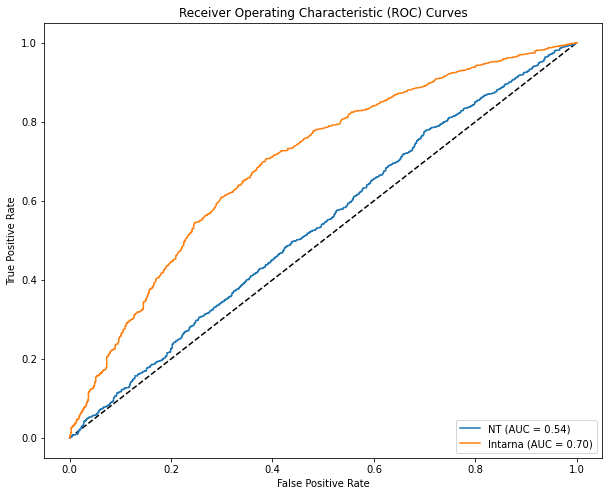

In [114]:
plot_roc_curves([{'prob': easypos_smartneg.probability, 'model_name': 'NT'},
                 {'prob': abs(easypos_smartneg.E_norm), 'model_name': 'Intarna'}
                ], easypos_smartneg.ground_truth)

#### Compare AUC based on confidence

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


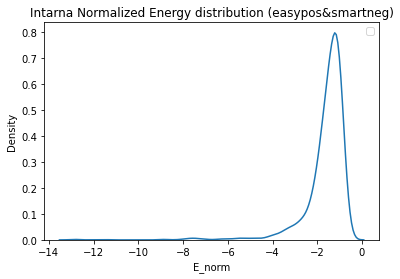

In [115]:
sns.kdeplot(easypos_smartneg.E_norm)
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

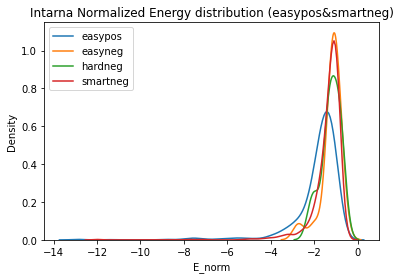

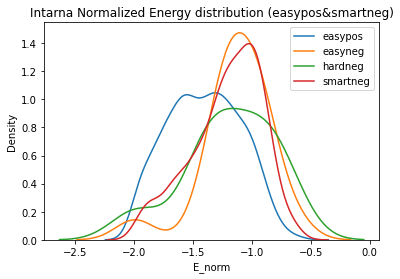

In [116]:
sns.kdeplot(res[res.policy == 'easypos'].E_norm, label = 'easypos')
sns.kdeplot(res[res.policy == 'easyneg'].E_norm, label = 'easyneg')
sns.kdeplot(res[res.policy == 'hardneg'].E_norm, label = 'hardneg')
sns.kdeplot(res[res.policy == 'smartneg'].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

treshold_plot = -2
sns.kdeplot(res[(res.policy == 'easypos')&(res.E_norm>treshold_plot)].E_norm, label = 'easypos')
sns.kdeplot(res[(res.policy == 'easyneg')&(res.E_norm>treshold_plot)].E_norm, label = 'easyneg')
sns.kdeplot(res[(res.policy == 'hardneg')&(res.E_norm>treshold_plot)].E_norm, label = 'hardneg')
sns.kdeplot(res[(res.policy == 'smartneg')&(res.E_norm>treshold_plot)].E_norm, label = 'smartneg')
plt.title(f'Intarna Normalized Energy distribution (easypos&smartneg)')
plt.legend()
plt.show()

In [117]:
def plot_ROC_based_on_confidence(df, how = 'intarna', treshold = 0.05, balance = False):
    if how == 'intarna':
        subset = df[
            (df.E_norm <= df.E_norm.quantile(treshold))|
            (df.E_norm >= df.E_norm.quantile(1-treshold))
        ]
    elif how == 'nt':
        subset = df[
            (df.probability <= treshold)|
            (df.probability >= (1-treshold))
        ]
    else:
        raise NotImplementedError
    print('perc of the total data: ', np.round(subset.shape[0]/df.shape[0], 3)*100, '%')
    if balance:
        subset = balance_df(subset)
    plot_roc_curves([{'prob': subset.probability, 'model_name': 'NT'},
                 {'prob': abs(subset.E_norm), 'model_name': 'Intarna'}
                ], subset.ground_truth)

perc of the total data:  10.100000000000001 %


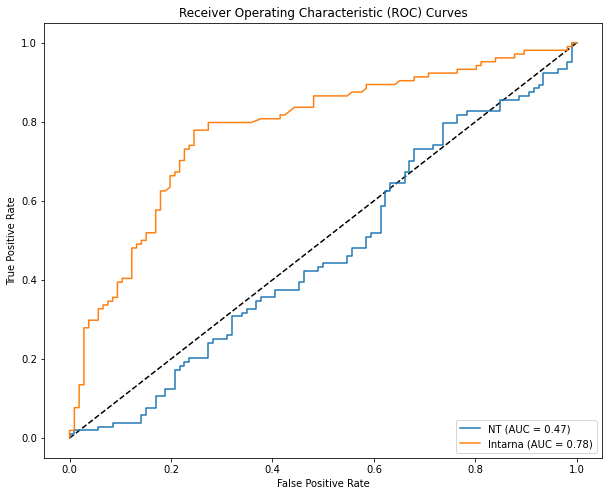

In [118]:
plot_ROC_based_on_confidence(easypos_smartneg, treshold = 0.05)

perc of the total data:  7.1 %


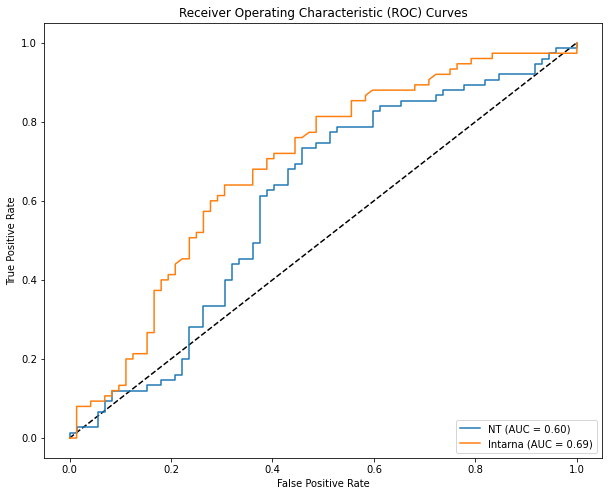

In [119]:
plot_ROC_based_on_confidence(easypos_smartneg, how = 'nt', treshold = 0.3)

Text(0.5, 0, 'Confidence & Perc%')

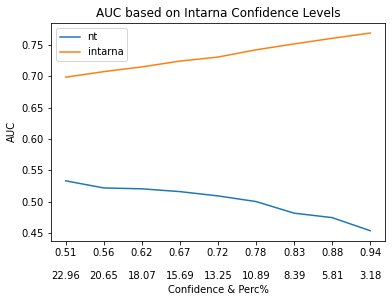

In [120]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'intarna', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on Intarna Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

Text(0.5, 0, 'Confidence & Perc%')

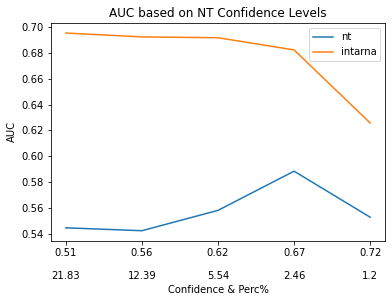

In [121]:
confidence_level, auc_nt, auc_intarna = collect_results_based_on_confidence_level(easypos_smartneg, how = 'nt', n_values = 10)

plt.plot(confidence_level, auc_nt, label = 'nt')
plt.plot(confidence_level, auc_intarna, label = 'intarna')
plt.title('AUC based on NT Confidence Levels')
plt.legend()

plt.ylabel('AUC')
plt.xlabel(f"Confidence & Perc%")

# XAI

In [38]:
df_genes_nt = pd.read_csv(os.path.join(metadata_dir, f'df_genes_nt_{how}.csv'))

DEVICE = 'cpu'

args_path = os.path.join(checkpoint_dir, 'args.pkl')

# Load the args namespace from the file
with open(args_path, 'rb') as f:
    args_dict = pickle.load(f)

# Convert the dictionary to an argparse.Namespace object
args = argparse.Namespace(**args_dict)
args.resume = os.path.join(checkpoint_dir, 'best_model.pth') # best_model

device = torch.device(DEVICE)
model = build_model(args)

checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'])

model.to(device)
model.eval()

BinaryClassifierNT1(
  (projection_module): NTProjectionModule(
    (conv1d): Conv1d(2560, 128, kernel_size=(1,), stride=(1,))
    (bn): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (small_cnn): SmallCNN(
    (conv1): Conv2d(256, 300, kernel_size=(2, 2), stride=(1, 1))
    (conv2): Conv2d(300, 300, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU()
    (maxpool2d): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (tanh): Tanh()
    (global_avg_pool): AdaptiveAvgPool2d(output_size=1)
    (fc): Linear(in_features=300, out_features=300, bias=True)
    (output_layer): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [39]:
xai = pd.read_csv(os.path.join(checkpoint_dir, f'gradcam_results_{how}500.csv'))
xai = xai.merge(res.filter([
    'couples', 'gene1_pc', 'gene2_pc', 'original_length1', 'original_length2', 'id_sample', 'g1', 'g2', 'gene1_original', 'gene2_original'
], axis = 1), left_on = 'id', right_on = 'id_sample')

In [40]:
gradcam_results = xai[xai.probability>0.5]

iou_value: 0.0436
iou_value_tr: 0.0414
iou_value_rand: 0.0248


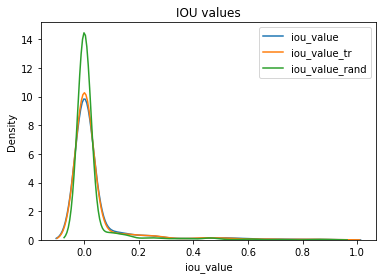

intensity: 0.5331
intensity_tr: 0.1928
intensity_rand: 0.5


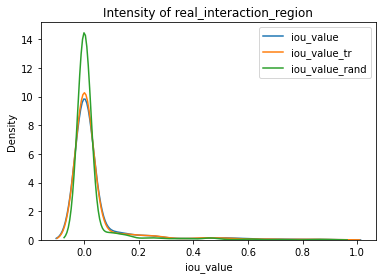

euclidean: 0.4784
euclidean_rand: 0.5076
euclidean_bbox_tr: 0.4809


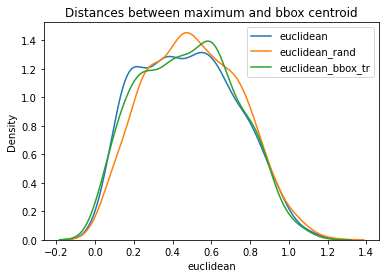

cos_sim: 0.22
cos_sim_tr: 0.13
cos_sim_rand: 0.19


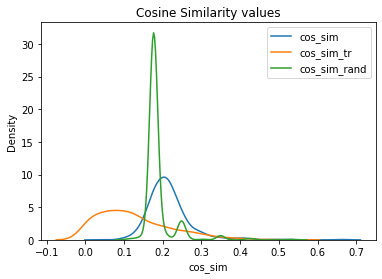

In [41]:
iou_columns = ['iou_value', 'iou_value_tr', 'iou_value_rand']
for c in iou_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'IOU values')
plt.legend()
plt.show()

intensity_columns = ['intensity', 'intensity_tr', 'intensity_rand']
for c in intensity_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in iou_columns:
    sns.kdeplot(gradcam_results[c], label = c)
    
plt.title(f'Intensity of real_interaction_region')
plt.legend()
plt.show()

euclidean_columns = ['euclidean', 'euclidean_rand', 'euclidean_bbox_tr']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid')
plt.legend()
plt.show()

cosine_sim_columns = ['cos_sim', 'cos_sim_tr', 'cos_sim_rand']
for c in cosine_sim_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 2))}')

for c in cosine_sim_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Cosine Similarity values')
plt.legend()
plt.show()

#### Subset XAI results

euclidean: 0.4784
euclidean_rand: 0.5076


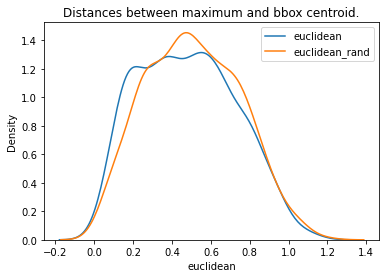

In [42]:
gradcam_results = gradcam_results[(gradcam_results.probability>0.5)]

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid.')
plt.legend()
plt.show()

In [43]:
def plot_query_results(query):
    for _, row in query.iterrows():
        x1_emb, x2_emb, y1_emb, y2_emb = int(np.round(row.x1/6)), int(np.round(row.x2/6)), int(np.round(row.y1/6)), int(np.round(row.y2/6))
        
        embedding1_path = os.path.join(embedding_dir, '32', row.gene1+'.npy')
        embedding2_path = os.path.join(embedding_dir, '32', row.gene2+'.npy')

        embedding1 = np.load(embedding1_path)[x1_emb:x2_emb :]
        embedding2 = np.load(embedding2_path)[y1_emb:y2_emb, :]

        rna1, rna2 = torch.as_tensor(embedding1).unsqueeze(0), torch.as_tensor(embedding2).unsqueeze(0)
        rna1, rna2 = torch.transpose(rna1, 1, 2), torch.transpose(rna2, 1, 2)

        rna1, rna2 = rna1.to(device), rna2.to(device)
        
        outputs = model(rna1, rna2)

        outputs[:, 1].backward()
        #print('prob:', outputs.softmax(-1)[:, 1])
        #print('degree:', row.abs_sum_diff)
        x1 = int(row.seed_x1-row.x1)
        x2 = int(row.seed_x2-row.x1)
        y1 = int(row.seed_y1-row.y1)
        y2 = int(row.seed_y2-row.y1)
        width = row.len1
        height = row.len2
        

        expl_matrix = gradcam(model, rna1, rna2, counterfactual = False, cnn_layer = 2)
        
        expl_matrix_reshaped = interpolate_expl_matrix(expl_matrix, height=height, width=width)
        
        # print(x1, x2, y1, y2)
        # print(expl_matrix_reshaped.shape)

        scaling_factor = 70

        plot_matrix(expl_matrix_reshaped, 
        [[y1, x1, y2-y1, x2-x1]], #crop_bbox =[x1hat, y1hat, what, hhat], 
        cmap ='viridis', 
        scaling_factor = scaling_factor)
        plt.show()

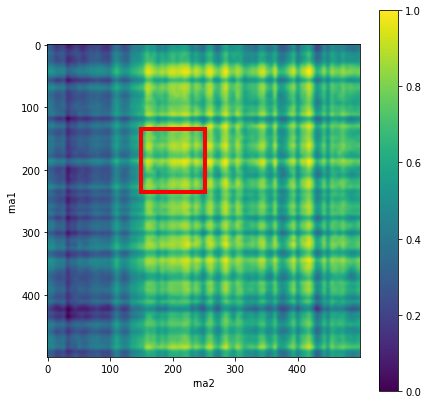

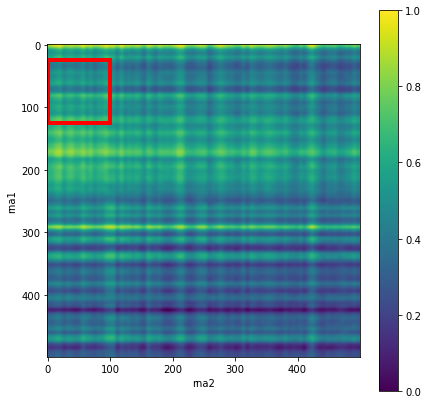

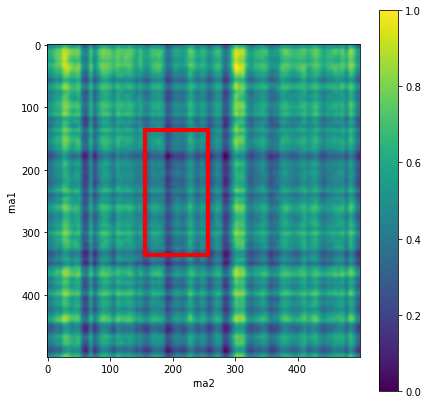

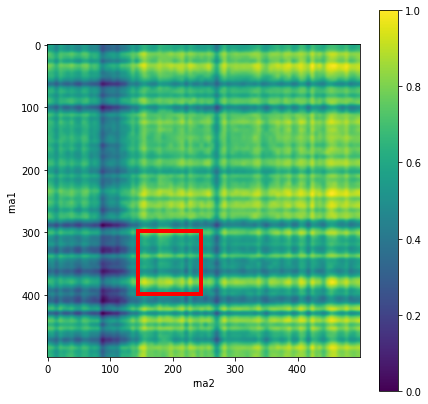

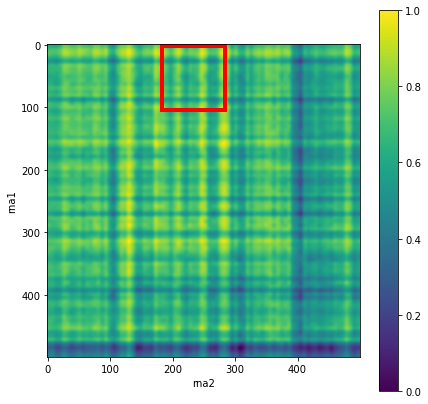

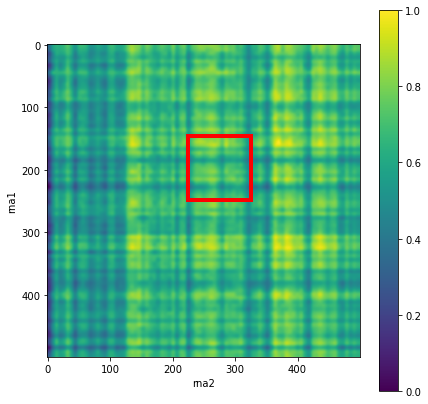

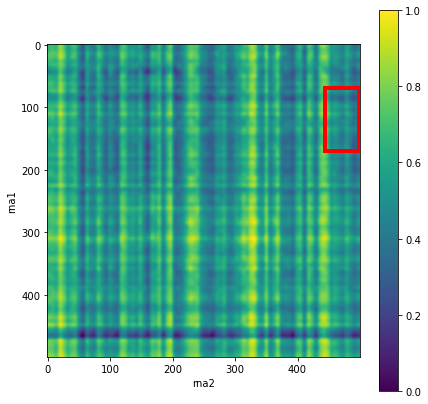

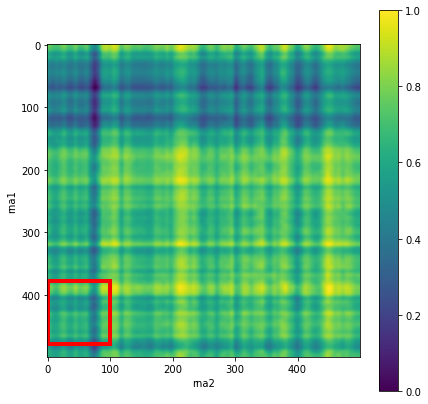

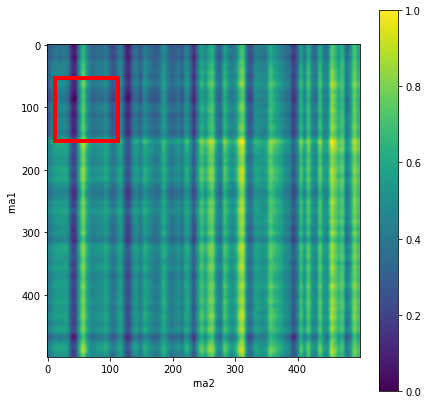

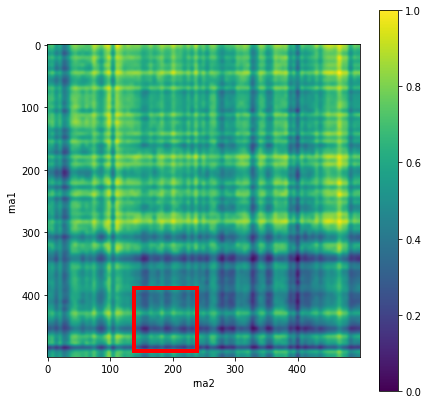

In [44]:
query = test500[test500.couples.isin(list(gradcam_results.sample(10).id))]
plot_query_results(query)

euclidean: 0.5007
euclidean_rand: 0.4885


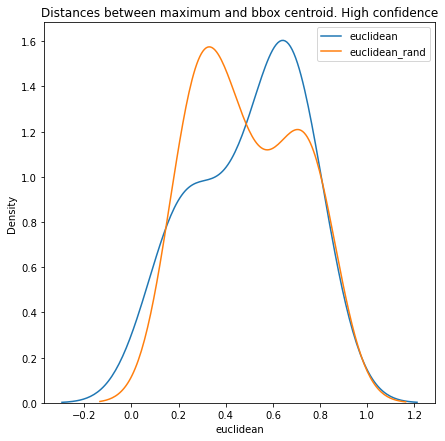

In [46]:
n_best = 20

gradcam_results = xai.sort_values('probability').tail(n_best)
#gradcam_results = xai.sort_values('iou_value').tail(n_best)
#gradcam_results = xai[(xai.probability>0.6)&(xai.probability<0.77)].sample(n_best)

euclidean_columns = ['euclidean', 'euclidean_rand']
for c in euclidean_columns:
    print(f'{c}: {str(np.round(gradcam_results[c].mean(), 4))}')

for c in euclidean_columns:
    sns.kdeplot(gradcam_results[c], label = c)
plt.title(f'Distances between maximum and bbox centroid. High confidence')
plt.legend()
plt.show()